# HW 6 Assignment 1
## Author: Sofiya Elyukin

### Collaborated with Sebastian Bana, Ben Alpert, and Scott Smith. Used building_nrg_instructions skeleton notebook and code from previous assignments. Other borrowed code attributed in comments.

## Getting and preparing energy data

In [1]:
from __future__ import print_function, division
import pandas as pd
import geopandas as gpd
import os
import pylab as pl
import urllib2
import json
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

s = json.load( open(os.getenv('PUI2016')+'/matplotlibrc.json') )
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [16]:
nrg = pd.read_csv(os.getenv("PUIDATA")+'/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013.csv')
nrg.head()

,Record Number,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [25]:
type(nrg['Record Number'][0])

numpy.int64

In [ ]:
scatter_matrix (nrg, s = 100, figsize=(16, 16))

In [3]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
nrg = nrg[[10, 21, int(25)]].copy()
#nrg.rename(columns = {'NYC Borough, Block, and Lot (BBL)': 'BBL'}, inplace = True)
nrg.head()

,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),BBL
0,NaN,918919,1.000410e+09
1,NaN,NaN,4.021460e+09
2,NaN,64200,2.027620e+09
3,NaN,NaN,1.006700e+09
4,NaN,50000,2.048300e+09


In [4]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [5]:
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')

indx2 = (np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)']))
print ("invalid entries changed to NaN %d"%sum(indx2))
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx2] = float('NaN')

invalid entries changed to NaN 15513
invalid entries changed to NaN 15430


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
nrg.head()

## Getting and preparing PLUTO data


In [6]:
def getPLUTO(url):
    a = os.system("curl -O " + url)
    print (a)
    a = os.system("unzip -jn mn_mappluto_16v1.zip MN*")
    print (a)
    a = os.system("mv " + "MN* " + os.getenv("PUIDATA") + "/MnPLUTO")
    print (a)
getPLUTO("https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip")

0
0
0


In [7]:
bsize = gpd.read_file (os.getenv("PUIDATA") + "/MnPLUTO/MNMapPLUTO.shp")
#bsize.head()

In [ ]:
bsize.columns

In [8]:
bsize = bsize[['BBL', 'UnitsTotal']].copy()
#bsize.head()

## Merging the two datasets

In [9]:
bblnrg = pd.merge(nrg, bsize, how='inner', on='BBL')
#bblnrg.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


In [10]:
bblnrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(bblnrg['Site EUI(kBtu/ft2)'], errors='coerce')
bblnrg.rename(columns = {'Reported Property Floor Area (Building(s)) (ft²)': 'Area (ft2)'}, inplace = True)
bblnrg['Area (ft2)'] = pd.to_numeric(bblnrg['Area (ft2)'], errors='coerce')

#scatter_matrix (bblnrg, s = 60, figsize=(16, 16))

In [11]:
#Find energy total per unit
bblnrg['TotalEnergy'] = bblnrg['Site EUI(kBtu/ft2)'] * bblnrg['Area (ft2)']

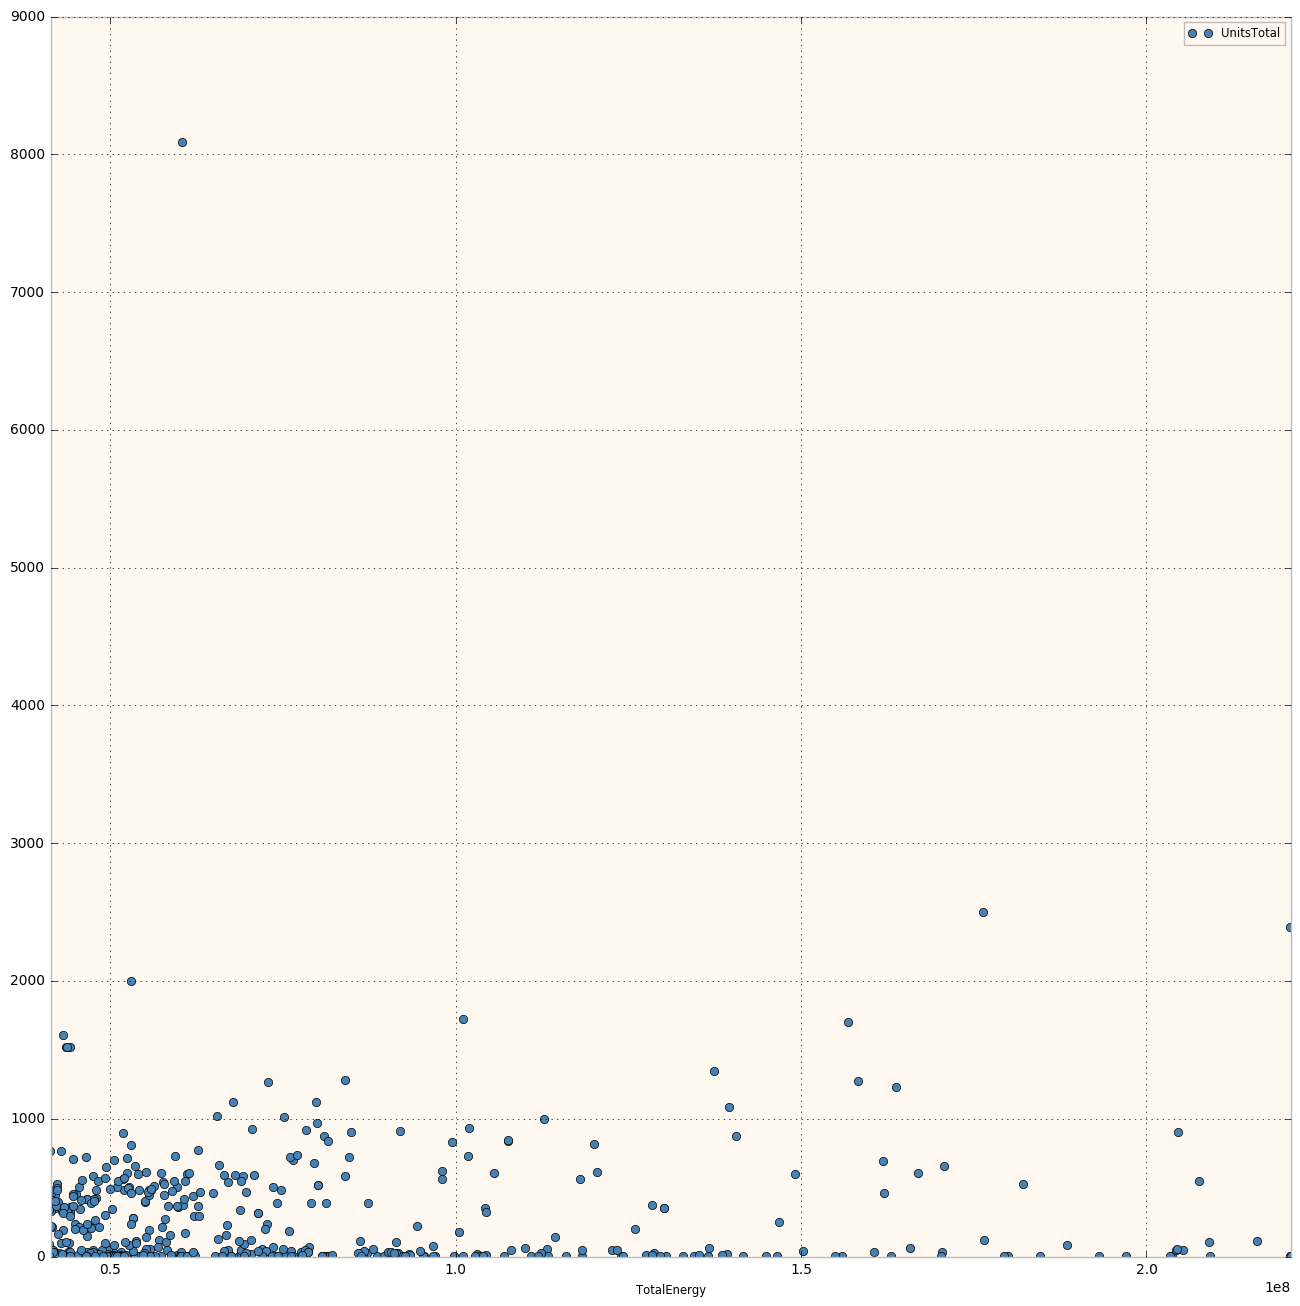

In [12]:
bblnrg = bblnrg[((bblnrg['TotalEnergy'] >= 1000) & (bblnrg.UnitsTotal != 0) )]
bblnrg.plot(x='TotalEnergy', y='UnitsTotal', style='o', figsize=(16,16))

In [ ]:
bblnrg.plot(x='TotalEnergy', y='UnitsTotal', style='o', xlim=(1000, 1e10), ylim=(1, 1000), figsize=(16, 16))

In [ ]:
bblnrg.plot(x='TotalEnergy', y='UnitsTotal', style='o', xlim=(1000, 1e10), ylim=(1, 1000), figsize=(16, 16), loglog=True,
           title='Energy Consumption (kBtu)')

In [ ]:
bblnrg.plot(x='UnitsTotal', y='TotalEnergy', style='o', xlim=(10,1000), ylim=(10000,1e11), figsize=(16, 16), loglog=True,
           title = 'Energy Consumption (kBtu)')

## Fitting a line: Units vs Energy

In [13]:
# Model: UnitsTotal is the independent variable which affects the dependent variable TotalEnergy
X = sm.add_constant(np.log10(bblnrg['UnitsTotal']))
linmodel = sm.OLS(np.log10(bblnrg['TotalEnergy']), X, missing='drop',).fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalEnergy   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     63.79
Date:                Wed, 26 Oct 2016   Prob (F-statistic):           1.70e-15
Time:                        20:14:20   Log-Likelihood:                -3867.6
No. Observations:                4997   AIC:                             7739.
Df Residuals:                    4995   BIC:                             7752.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.9116      0.020    353.804      0.000         6.873     6.950
UnitsTotal     0.0865      0.011      7.987      0.000         0.065     0.108
==============================================================================
Omnibus:                     2221.478   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27205.366
Skew:                           1.791   Prob(JB):                         0.00
Kurtosis:                      13.855   Cond. No.                         6.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TypeError: figaspect() takes exactly 1 argument (2 given)

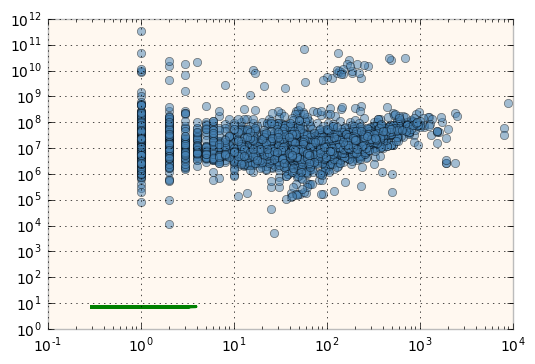

In [14]:
#Attempts at plotting model with points 
pl.plot(np.log10(bblnrg['UnitsTotal']), linmodel.predict(), color='green')
pl.loglog(bblnrg['UnitsTotal'], bblnrg['TotalEnergy'], 'o', alpha=0.5)
pl.figaspect(16,16) #error says 1 arg, but that only plots points, 2 args plots points+line.
                     #removing .figaspect shrinks y-axis and as a result doesn't show line.
pl.xlim(10,1000)
pl.ylim(10000,1e11)

## Fitting a line: Energy vs Units

In [ ]:
# Model: TotalEnergy is the independent variable which affects the dependent variable UnitsTotal
X2 = sm.add_constant(np.log10(bblnrg['TotalEnergy']))
linmodel2 = sm.OLS(np.log10(bblnrg['UnitsTotal']), X2, missing='drop').fit()
linmodel2.summary()

In [ ]:
#same error as above, but the model does work because the line comes up differently
pl.plot(np.log10(bblnrg['TotalEnergy']), linmodel2.predict(), color='green')
pl.loglog(bblnrg['TotalEnergy'], bblnrg['UnitsTotal'], 'o', alpha=0.5)
pl.figaspect(16,16)   
pl.xlim(1000, 1e10)
pl.ylim(1, 1000)

## Fitting the lines with code that works

In [ ]:
# Code from Ben Alpert, using https://www.wired.com/2011/01/linear-regression-with-pylab/
x=np.log(bblnrg['UnitsTotal'])
y=np.log(bblnrg['TotalEnergy'])

(m,b) = polyfit(x,y,1)
yp = polyval([m,b],x)

pl.figure(figsize=(16,16))
pl.title('Line Fitting Test')
pylab.xlabel('Units Total')
pylab.ylabel('Energy Total')
pl.xlim(-1, 10)
pl.ylim(7, 28)
pl.scatter(x, y)
pl.plot(x, yp, color="red")
grid(True)
pl.show()
print ("Fitting a line so the number of units in a building is the predictor of its total energy consumption results in a \
line which vaguely follows the shape of the observed data points.")

In [ ]:
x2=np.log(bblnrg['TotalEnergy'])
y2=np.log(bblnrg['UnitsTotal'])

(m2,b2) = polyfit(x2,y2,1)
yp2 = polyval([m2,b2],x2)

pl.figure(figsize=(16,16))
pl.title('Line Fitting Test')
pylab.ylabel('Units Total')
pylab.xlabel('Energy Total')
pl.xlim(7, 28)
pl.ylim(-1, 10)
pl.scatter(x2, y2)
pl.plot(x2, yp2, color="red")
grid(True)
pl.show()
print ('The model does not fit the data nearly as well when you set total  energy consumption to predict the number of units.')

## Chi-square

In [ ]:
# from HW4
# http://faculty.washington.edu/stuve/log_error.pdf --> observations = log(y), so error of obs = error of log(y)
'''def evalChisq(model, data):
    model = linmodel
    data = np.log10(bblnrg['TotalEnergy']
    for j in range(len(model[0])):     # need to adjust "for loop", keep getting SyntaxError at ':'
        for i in range(2):
            E = (np.sqrt(log10(data)))
    return ((model - date) ** 2) / E).sum'''

## Fit 2nd Degree Polynomial

In [ ]:
# From https://github.com/fedhere/PUI2016_fb55/blob/master/Lab6_fb55/inClassFitThu.ipynb
# xyd = pd.DataFrame()
# xyd['X'] = x
# xyd['y'] = y
# xyd['X2'] = x*x
# cres = smf.ols(formula = 'y ~ X2 + X', data=xyd).fit()

'''xyd = pd.DataFrame()
xyd['X'] = (np.log(bblnrg['UnitsTotal']))
xyd['y'] = np.log(bblnrg['TotalEnergy'])
xyd['X2'] = xyd['X']*xyd['X']
linmodelpoly = smf.OLS(formula = 'y ~ X2 + X', data=xyd).fit() #get error that not enough args provided 
pl.plot(xyd['X'], linmodelpoly.predict(xyd), '--')
linmodelpoly.summary()'''

#changed .OLS to .ols
xyd = pd.DataFrame()
xyd['X'] = (np.log(bblnrg['UnitsTotal']))
xyd['y'] = np.log(bblnrg['TotalEnergy'])
xyd['X2'] = xyd['X']*xyd['X']
linmodelpoly = smf.ols(formula = 'y ~ X2 + X', data=xyd).fit() #get error that not enough args provided 
pl.plot(xyd['X'], linmodelpoly.predict(xyd), '--')

In [ ]:
# Create 2nd degree polynomial fit by adjusting earlier code...didn't exactly work...
x=np.log(bblnrg['UnitsTotal'])
#x=np.linspace(np.log(bblnrg['UnitsTotal']).min, np.log(bblnrg['UnitsTotal']).max, 1000) doesn't work
y=np.log(bblnrg['TotalEnergy'])

z = polyfit(x,y,2)
yp = polyval(z,x)

pl.figure(figsize=(16,16))
pl.title('Line Fitting Test')
pylab.xlabel('Units Total')
pylab.ylabel('Energy Total')
pl.xlim(-1, 10)
pl.ylim(7, 28)
pl.scatter(x, y)
pl.plot(x, yp, color="red")
grid(True)
pl.show()

## NEED TO SORT UNITS TOTAL

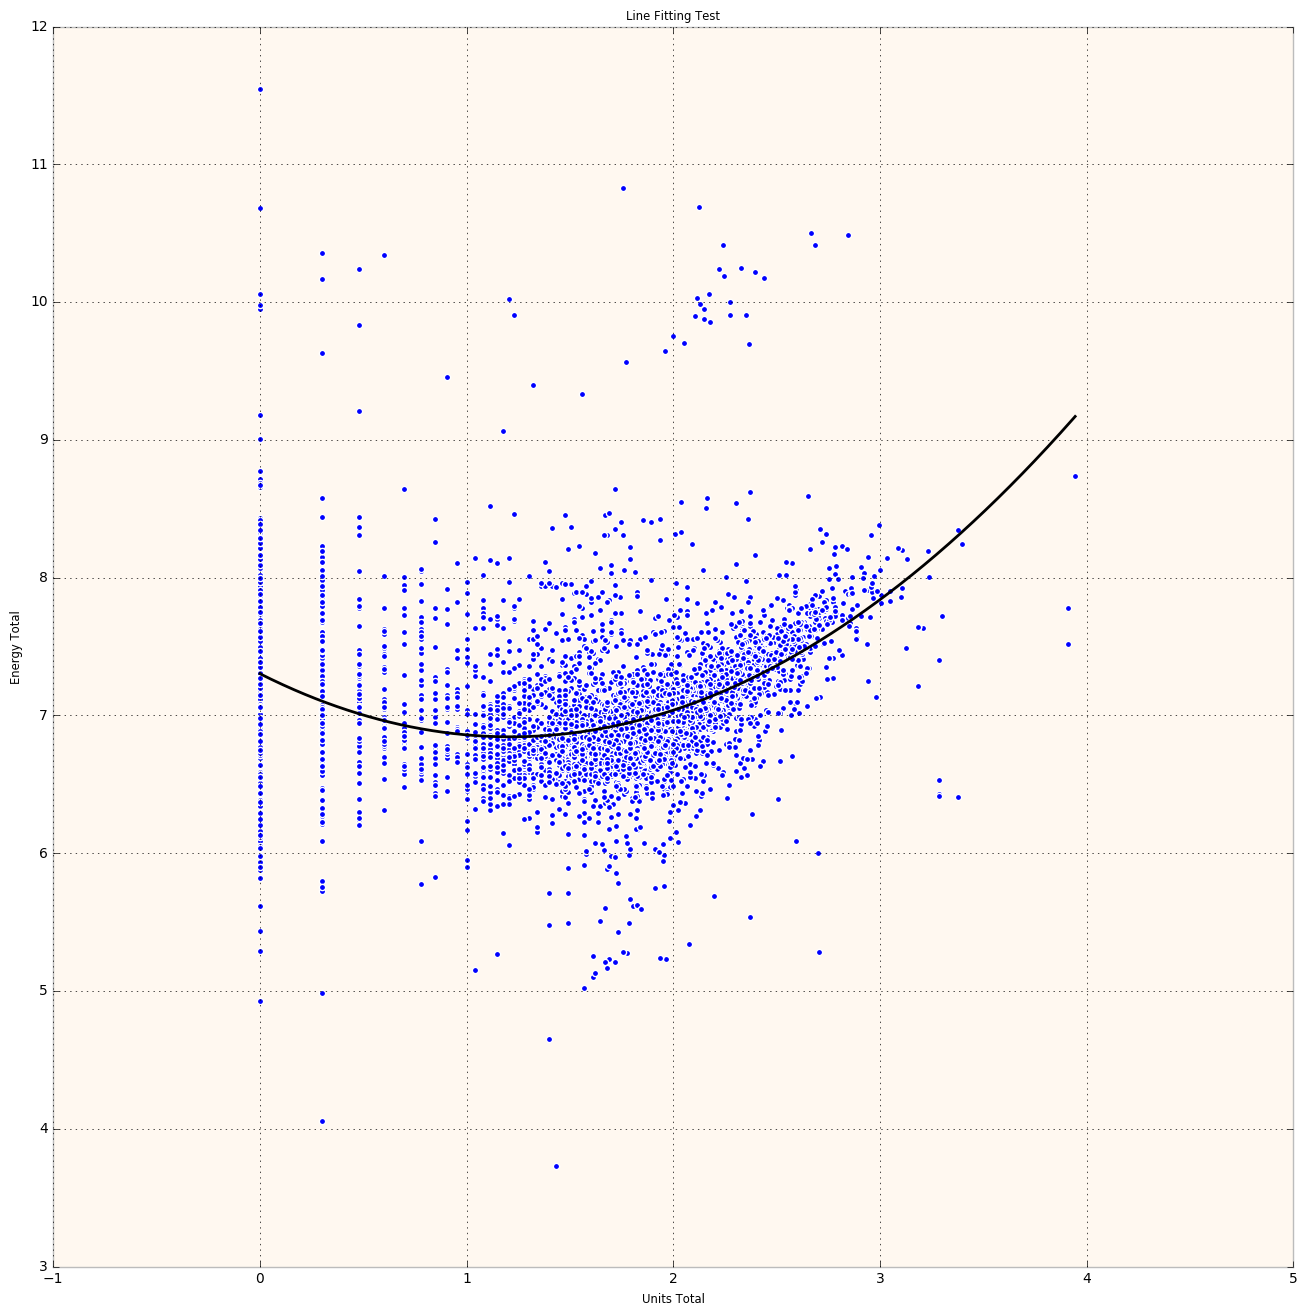

In [26]:
# Using fedhere's solution and bits of my attempts

bblnrg['units']=np.log10(bblnrg['UnitsTotal'])
bblnrg['energy']=np.log10(bblnrg['TotalEnergy'])

X=np.linspace(bblnrg['units'].min(), bblnrg['units'].max(), 1000)
linmodelcurve = smf.ols(formula = 'energy ~ units + I(units**2)', data = bblnrg).fit()

pl.figure(figsize=(16,16))
pl.title('Line Fitting Test')
pylab.xlabel('Units Total')
pylab.ylabel('Energy Total')
pl.scatter(np.log10(bblnrg.UnitsTotal), np.log10(bblnrg.TotalEnergy))
plot(X, linmodelcurve.predict(exog = dict(units = X)), 'k')

In [ ]:
#kept trying
'''import scipy as sp
x=np.log(bblnrg['UnitsTotal'])
y=np.log(bblnrg['TotalEnergy'])

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

sp.optimize.curve_fit(x, y)'''